# The Factor Analysis for Constructing a Composite Index
_Create an education index from Indonesia’s Central Statistics Agency data 2020_

Policymakers are required to formulate comprehensive policies and be able to assess the areas that need improvement. Using the composite index, the indicators are aggregated and each area can be ranked to create an evaluation.

The idea behind the Factor Analysis (FA)
Factor analysis is a linear statistical model that aims to describe a set of m variables in terms of a smaller number of p factors and to highlight the relationship between these variables. Factor analysis is similar to Principal Component Analysis (PCA).

The factor analysis helps the analyst to make an interpretation among the variables in the data into a set of factors. Factors consist of one or several variables with certainly explained variances. It is commonly used in market research, advertising, etc.

[Learn more about factor analysis to get the detailed formula and concept](https://www.ndsu.edu/faculty/horsley/Factor_analysis_(HZAU).pdf)


## Hands-on Tutorial
To perform factor analysis and create a composite index or in this tutorial, education index, there are several modules in Python that must be installed first in the Anaconda Prompt.

   - pandas — used for data manipulation, such as slicing, aggregation, etc.
   - numpy — used for linear algebra calculation
   - factor_analyzer — used for factor analysis, performing adequacy tests, communality calculation, loading factors calculation, etc.
   - plotnine — used for data visualization. It’s quite similar with ggplot2 in R
   - scikit-learn — used for data standardization
   - geopandas — used for visualizing geospatial data
   - folium — used for making choropleth map
   - branca — used for generating HTML and JavaScript pages with Python

In [1]:
# Module for data manipulation
import pandas as pd
# Module for linear algebra calculation
import numpy as np
# Module for constructing the data
from sklearn.datasets import make_regression
# Module for factor analysis
from factor_analyzer import FactorAnalyzer
# Module for adequacy test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
# Module for standardization
from sklearn.preprocessing import MinMaxScaler
# Module for data viz
from plotnine import *
import plotnine
import matplotlib.pyplot as plt
# Module for spatial data manipulation
import geopandas as gpd
# Module for spatial data viz
import folium
import branca
import branca.colormap as cm
from folium.features import GeoJson, GeoJsonTooltip
# Module for json file
import json

To make us easier to understand and get insights from the data, we will apply conditional formatting using the pandas method — [style](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html). The styles will highlight the three main values — loading factors, communality, and eigenvalue as the result of factor analysis. The cell in the data frame will be highlighted with a background color yellow if they meet certain criteria.

In [2]:
# Functions
def highlightLoadings(x):
    '''
    highlight the values if they are greater than 0.5 in a Series yellow.
    '''
    return ['background-color: yellow' if abs(v) > 0.5 else '' for v in x]
def highlightCommunalities(x):
    '''
    highlight the values if they are greater than 0.5 in a Series yellow.
    '''
    return ['background-color: yellow' if v > 0.5 else '' for v in x]
def highlightEigenvalue(x):
    '''
    highlight the values if they are greater than 1 in a Series yellow.
    '''
    return ['background-color: yellow' if v > 1 else '' for v in x]

The data for this tutorial is provided by Indonesia’s Central Statistics Agency. The data consists of 34 rows — represents the 34 provinces in Indonesia and 30 columns (25 columns are the indicators for education index while 5 columns are identifier, area code, and helper for further analysis).

Get the [data set](https://github.com/audhiaprilliant/audhiaprilliant.github.io/blob/master/assets/docs/BPS%20Indonesia%20Education%20Index%20-%20Processed%20Eng.xlsx) and [json file](https://github.com/audhiaprilliant/audhiaprilliant.github.io/blob/master/assets/docs/prov_light.json) for the tutorial!

In [3]:
# Read the dataframe
df = pd.read_excel('./data/BPS Indonesia Education Index - Processed Eng.xlsx', engine = 'openpyxl', sheet_name = 'Data')
# Drop NaN
df.dropna(inplace = True, axis = 1)
# Dimension of data
print('Dimension of data: {} rows and {} columns'.format(len(df), len(df.columns)))
df.head()

Dimension of data: 34 rows and 30 columns


,Province,Code,Region,Population,HDI,X1,X2,X3,X4,X5,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25
0,ACEH,11,West,5388.1,71.99,0.051321,0.049048,0.046932,0.040260,10.72,...,32.50,108.70,97.79,90.90,37.15,99.03,86.87,70.70,27.34,9.71
1,NORTH SUMATERA,12,West,14798.4,71.77,0.044705,0.037903,0.034175,0.038862,16.07,...,26.98,108.53,91.68,94.68,25.76,97.73,80.56,68.00,19.67,9.83
2,WEST SUMATERA,13,West,5545.7,72.38,0.049760,0.041749,0.035463,0.033911,13.06,...,35.96,108.68,92.33,90.01,36.56,98.80,78.41,68.90,28.55,9.34
3,RIAU,14,West,6951.2,72.71,0.041208,0.039844,0.035384,0.038516,16.84,...,28.35,105.89,94.89,84.61,28.74,97.73,80.48,64.01,23.06,9.47
4,JAMBI,15,West,3604.2,71.29,0.047939,0.043825,0.036182,0.039739,10.29,...,23.75,109.39,88.91,83.71,25.69,99.11,79.93,61.38,18.71,8.97


The indicators are coming from 7 main sections, these sections are detailed by education levels (elementary school, junior high school, senior high school, vocational high school, and university).

-    The proportion of the number of classrooms and students at the education levels for the academic year 2019/2020
-    Percentage of classrooms in good condition at the education levels for the academic year 2019/2020
-    Percentage of eligible teachers at the education levels for the academic year 2019/2020
-    School enrollment rate (APS) at age group 7–12 years in 2020
-    Gross enrollment rate (APK) by education levels in 2020
-    Net enrollment rate (APM) by education levels in 2020
-    The average length of the school year for population aged 15+ years in 2020

The 5 columns that are not the indicators — they are helper, will be removed. they will help the further analysis and visualization. After we have the indicators in the df_fix data frame, we must standardize them using min-max scaler, into scale 0–1.

In [4]:
# Filter the numerical data
df_fix = df[[col for col in list(df.columns) if col not in ['Province', 'Code', 'Region', 'Population', 'HDI']]]
# Standardize the factors
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(data = scaler.fit_transform(df_fix),
                         columns = df_fix.columns)
df_scaled.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25
0,0.547020,1.000000,1.000000,0.454429,0.086659,0.104676,0.056815,0.150266,0.806622,0.879837,...,0.437682,0.787619,0.834383,0.703125,0.495894,0.972346,0.994967,0.904248,0.446814,0.653207
1,0.353110,0.378600,0.197898,0.400034,0.239168,0.322795,0.432890,0.462434,0.937923,0.865580,...,0.276937,0.779937,0.559406,0.854567,0.267775,0.908148,0.913537,0.810237,0.242335,0.681710
2,0.501272,0.593056,0.278911,0.207457,0.153364,0.274708,0.371905,0.768285,0.822047,0.754582,...,0.538439,0.786715,0.588659,0.667468,0.484078,0.960988,0.885792,0.841574,0.479072,0.565321
3,0.250608,0.486813,0.273924,0.386593,0.261117,0.326514,0.481366,0.685505,0.846125,0.776986,...,0.316832,0.660642,0.703870,0.451122,0.327458,0.908148,0.912505,0.671309,0.332711,0.596200
4,0.447906,0.708768,0.324114,0.434177,0.074401,0.088735,0.000000,0.000000,0.830700,0.885947,...,0.182877,0.818798,0.434743,0.415064,0.266373,0.976296,0.905407,0.579735,0.216742,0.477435


In factor analysis, to test the feasibility of a data set for factor analysis is to perform the Bartlett and Kaiser-Meyer-Olkin (KMO) test.

Bartlett test is a test for _homogeneity of variances_ in which the null hypothesis is that all k population variances are equal against the alternative that at least two are different.

In [5]:
# Adequacy test - Bartlett’s test
chiSquareValue, pValue = calculate_bartlett_sphericity(df_scaled)
print('Chi-square value : {}'.format(round(chiSquareValue, ndigits = 3)))
print('p-value          : {}'.format(round(pValue, ndigits = 5)))

Chi-square value : 1045.341
p-value          : 0.0


_The Bartlett test produces a p-value that is less than 0.05. It means, we reject the null hypothesis or in this case, at least two population variances are different._

Further, the KMO test is used to measure the sampling adequacy for factor analysis — how good the data is. KMO value that is greater than 0.5 indicates that the data is suitable for factor analysis.

In [6]:
# Adequacy test - Kaiser-Meyer-Olkin test
KMO, KMO_model = calculate_kmo(df_scaled)
print('KMO value : {}'.format(round(KMO_model, ndigits = 3)))

KMO value : 0.364


C:\ProgramData\Anaconda3\lib\site-packages\factor_analyzer\utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.


_The KMO test produces a KMO value 0.364 which is less than the standard 0.5_

In addition, variables that have a communality value of less than 0.5 need to be eliminated. The communality is the proportion of each variable’s variance that can be explained by the factors.

In [7]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 25, rotation = None)
fa.fit(df_scaled)
# The communalities
df_communalities = pd.DataFrame(data = {'Column': df_scaled.columns, 'Communality': fa.get_communalities()})
df_communalities.style.apply(highlightCommunalities, subset = ['Communality'])

,Column,Communality
0,X1,0.995006
1,X2,0.995029
2,X3,0.995004
3,X4,0.995007
4,X5,0.995109
5,X6,0.995190
6,X7,0.995008
7,X8,0.995025
8,X9,0.995053
9,X10,0.995008


The yellow color indicates that the communality values meet the criteria — greater than 0.5. It means, 25 columns are used for factor analysis — none of the variables will be eliminated.

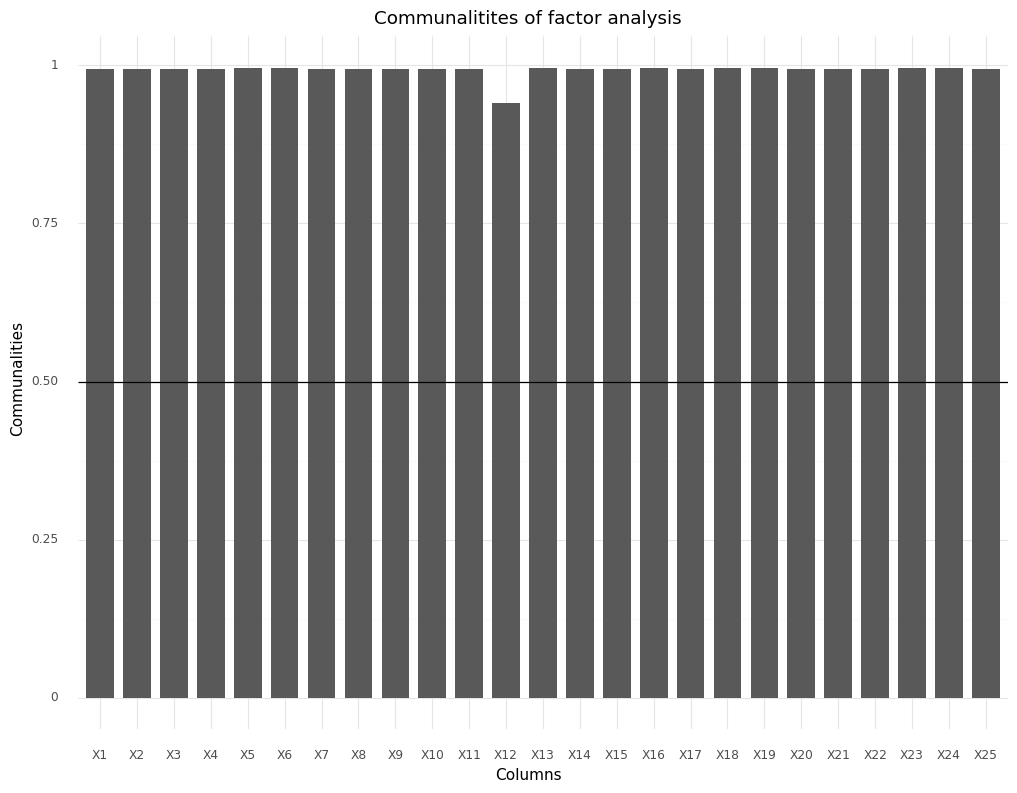

<ggplot: (136904816562)>

In [8]:
# Data viz
plotnine.options.figure_size = (12, 9)
communality_bar = (
    ggplot(data = df_communalities)+
    geom_bar(aes(x = 'Column',
                 y = 'Communality'),
             width = 0.75,
             stat = 'identity')+
    geom_hline(yintercept = 0.5)+
    scale_x_discrete(limits = df_communalities['Column'].tolist())+
    labs(title = 'Communalitites of factor analysis')+
    xlab('Columns')+
    ylab('Communalities')+
    theme_minimal()
)
# Display the viz
communality_bar

The steps to take after the indicators are selected are to determine the number of factors, to interpret these factors, and to determine the weight for each factor.

The determination of the factors in this tutorial is based on the Kaiser criteria, namely factors with an eigenvalue is greater than 1 are included as one dominant indicator.

In [9]:
# Check Eigenvalues
eigenValue, value = fa.get_eigenvalues()
eigenValue

array([7.08937021e+00, 5.43716636e+00, 3.16822002e+00, 1.70856516e+00,
       1.54548873e+00, 1.41838147e+00, 9.61205005e-01, 8.75131668e-01,
       7.28919455e-01, 5.29027173e-01, 4.24890455e-01, 2.88490634e-01,
       2.17630337e-01, 1.49947052e-01, 1.11817362e-01, 9.55623077e-02,
       8.18211212e-02, 5.75573589e-02, 4.71429794e-02, 2.06933743e-02,
       1.63697890e-02, 1.19162444e-02, 9.10243768e-03, 4.82771425e-03,
       7.55573850e-04])

The eigenvalues will be represented in the data frame and apply the yellow highlight to make us easier to determine the number of factors.

In [10]:
# Convert the results into a dataframe
df_eigen = pd.DataFrame({'Factor': range(1, len(eigenValue) + 1), 'Eigen value': eigenValue})
df_eigen.style.apply(highlightEigenvalue, subset = ['Eigen value'])

,Factor,Eigen value
0,1,7.089370
1,2,5.437166
2,3,3.168220
3,4,1.708565
4,5,1.545489
5,6,1.418381
6,7,0.961205
7,8,0.875132
8,9,0.728919
9,10,0.529027


According to the Kaiser criteria, the number of factors generated is 6. It means that the 25 columns or well-known variables will be grouped and interpreted into 6 factors.

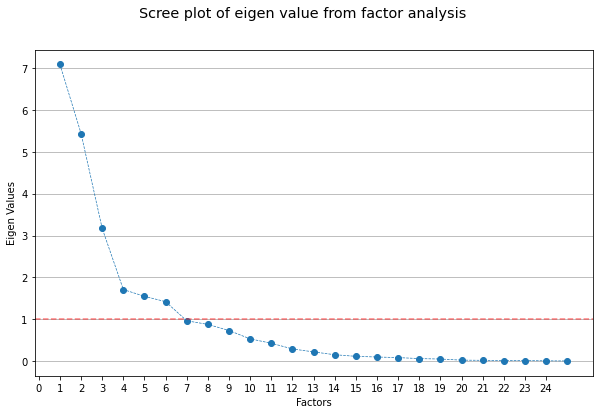

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df_eigen["Factor"], df_eigen["Eigen value"], 'o--', linewidth = 0.7)
plt.grid(axis='y')
plt.xticks([i for i in range(len(df_eigen["Factor"]))])
plt.xlabel("Factors")
plt.ylabel("Eigen Values")
plt.suptitle("Scree plot of eigen value from factor analysis ", fontsize= "x-large")
plt.axhline(y = 1.0, color = 'red', alpha = 0.5, linestyle = '--')
plt.show()

Determination of the dominant indicator in a factor is based on the largest value of loading factors in an indicator.

In [13]:
n_factor = 6
# Factor analysis without rotation
fa = FactorAnalyzer(n_factors = n_factor, rotation = None)
fa.fit(df_scaled)
# Create a factor's names
facs = ['Factors' + ' ' + str(i + 1) for i in range(n_factor)]
print(facs)
# Loading factors
pd.DataFrame(data = fa.loadings_, index = df_scaled.columns, columns = facs).style.apply(highlightLoadings)

['Factors 1', 'Factors 2', 'Factors 3', 'Factors 4', 'Factors 5', 'Factors 6']


,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
X1,-0.088154,0.645762,0.201730,0.192564,0.158142,-0.051111
X2,-0.106023,0.776502,0.232927,0.168349,0.253025,0.178572
X3,0.215744,0.567222,-0.125862,-0.115621,0.286634,0.269899
X4,-0.154060,0.691620,-0.195333,0.133001,0.429184,0.112041
X5,0.345182,-0.587718,-0.487819,0.193630,0.375371,0.096973
X6,0.450933,-0.713172,-0.401999,0.213098,0.287999,-0.044280
X7,0.397190,-0.782536,-0.149440,0.268428,0.103330,0.020780
X8,0.367294,-0.458908,-0.121690,0.183385,0.040418,-0.349634
X9,0.635399,-0.386708,0.519768,0.133266,-0.183094,0.106667
X10,0.612005,-0.123334,0.573455,0.185857,-0.133716,0.156792


From the image above, we can’t determine the dominant indicator in a certain factor because there is a lot of value similar. It happens if we perform factor analysis without rotation. But, it’s okay we will perform the factor rotation after getting the explained variance in the factor analysis without rotation.

In [45]:
# Explained variance
idx = ['Sum of Squared Loadings', 'Proportion Variance', 'Cumulative Variance']
df_variance = pd.DataFrame(data = fa.get_factor_variance(), index = idx, columns = facs)
# Ratio of variance
ratioVariance = fa.get_factor_variance()[1] / fa.get_factor_variance()[1].sum()
df_ratio_var = pd.DataFrame(data = ratioVariance.reshape((1, n_factor)), index = ['Ratio Variance'], columns = facs)
# New completed dataframe
df_variance.append(df_ratio_var)


,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
Sum of Squared Loadings,6.959552,5.219973,3.012464,1.474913,1.312487,0.987474
Proportion Variance,0.278382,0.208799,0.120499,0.058997,0.052499,0.039499
Cumulative Variance,0.278382,0.487181,0.607680,0.666676,0.719176,0.758675
Ratio Variance,0.366932,0.275215,0.158828,0.077763,0.069199,0.052063


The total explained variance is about 75.86% (cf last cell of cumulative variance row). It means nearly 75.86% of the variability in the original 25 variables, so we can considerably reduce the complexity of the data set by using these components, with only a 24.14% loss of information.

_The acceptable explained variance in factor analysis for to be valid is 60%_

The difficulty in choosing the dominant indicators in a certain factor is solved by applying the factor rotation. We need to perform factor rotation to overcome an indicator that has a loading factor that is almost similar to a factor.

The rotation uses the varimax method. After that, the interpretation of each factor is carried out based on the dominant indicator that makes up the factor.

In [46]:
# Factor analysis with rotation
fa = FactorAnalyzer(n_factors = n_factor, rotation = 'varimax')
fa.fit(df_scaled)
# Create a factor's names
facs = ['Factors' + ' ' + str(i + 1) for i in range(n_factor)]
print(facs)
# Loading factors
pd.DataFrame(data = fa.loadings_, index = df_scaled.columns, columns = facs).style.apply(highlightLoadings)

['Factors 1', 'Factors 2', 'Factors 3', 'Factors 4', 'Factors 5', 'Factors 6']


,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
X1,0.086515,-0.385899,-0.077736,0.184285,0.571311,-0.085869
X2,0.079639,-0.414097,-0.081965,0.183481,0.745538,0.136647
X3,-0.045179,-0.066811,0.334558,0.224066,0.555754,0.273859
X4,-0.278431,-0.134528,0.024528,0.203735,0.784594,0.036758
X5,-0.077399,0.934030,0.068199,0.006447,-0.082567,-0.020397
X6,0.069244,0.956030,0.086516,-0.004298,-0.235941,-0.148027
X7,0.249757,0.808739,-0.086514,-0.046177,-0.380317,-0.070150
X8,0.210711,0.484274,0.078680,0.036182,-0.278764,-0.392031
X9,0.844127,0.212339,0.036031,0.017154,-0.332927,0.126583
X10,0.859366,0.067980,0.022386,0.109262,-0.111154,0.166412


[Learn more about how to interpret the factors in factor analysis!](https://stats.oarc.ucla.edu/spss/seminars/introduction-to-factor-analysis/a-practical-introduction-to-factor-analysis/)

The factor analysis will use the rotation method and the important value from the factor analysis besides the factor score, also the ratio of explained variance in the 6 factors. It will be used as the weighting to create a composite index.

In [47]:
# Explained variance
idx = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
df_variance = pd.DataFrame(data = fa.get_factor_variance(), index = idx, columns = facs)
# Ratio of variance
ratioVariance = fa.get_factor_variance()[1] / fa.get_factor_variance()[1].sum()
df_ratio_var = pd.DataFrame(data = ratioVariance.reshape((1, n_factor)), index = ['Ratio Variance'], columns = facs)
# New completed dataframe
df_variance.append(df_ratio_var)

,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
SS Loadings,4.398885,3.818808,3.514422,3.341996,2.860190,1.032562
Proportion Variance,0.175955,0.152752,0.140577,0.133680,0.114408,0.041302
Cumulative Variance,0.175955,0.328708,0.469285,0.602964,0.717372,0.758675
Ratio Variance,0.231925,0.201341,0.185293,0.176202,0.150799,0.054440


The total explained variance is about 75.86%. It’s similar without rotation using the varimax method.

In [48]:
# The factor scores
df_factors = pd.DataFrame(data = fa.fit_transform(df_scaled),
                          index = pd.MultiIndex.from_frame(df[['Province', 'Region']]),
                          columns = facs)
df_factors

,,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
Province,Region,,,,,,
ACEH,West,0.213151,-0.181858,0.527530,1.128943,0.788172,1.702225
NORTH SUMATERA,West,-0.447379,-0.341386,1.361850,-1.108200,-0.665725,0.635541
WEST SUMATERA,West,0.320698,-1.232980,1.886044,-0.360122,-0.926783,-1.116187
RIAU,West,-0.066843,0.959367,-1.119813,1.548194,0.048667,1.492447
JAMBI,West,0.789713,-1.075963,1.069349,-1.614698,1.224877,0.684390
SOUTH SUMATERA,West,0.228829,-0.567252,-0.492303,0.030032,-1.071543,-0.437447
BENGKULU,West,0.252115,-1.363703,0.954648,-0.097229,0.633134,-0.307455
LAMPUNG,West,0.687480,-2.861992,2.931481,-3.058802,-1.144177,-1.304143
BANGKA BELITUNG ISLAND,West,0.837486,0.928729,-1.751948,-1.553879,0.076898,-0.052605


The factor scores generated by factor analysis are in a z-score. Automatically, the value range from positive to negative. Factor scores with such ranges will make analysis difficult because they cannot know the maximum and minimum values that can be achieved.

Therefore, to facilitate interpretation, the factor scores are transformed into an index that has a maximum value of 1 and a minimum of 0. It’s helped by min-max standardization.

In [49]:
# Standardize the factors
scaler = MinMaxScaler()
df_factors_scaled = pd.DataFrame(data = scaler.fit_transform(df_factors),
                                 index = pd.MultiIndex.from_frame(df[['Province', 'Region']]),
                                 columns = facs)
df_factors_scaled

,,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
Province,Region,,,,,,
ACEH,West,0.870933,0.437357,0.601761,0.540391,0.629395,0.863621
NORTH SUMATERA,West,0.764418,0.411324,0.739975,0.251708,0.285020,0.666345
WEST SUMATERA,West,0.888276,0.265830,0.826813,0.348240,0.223185,0.342375
RIAU,West,0.825782,0.623587,0.328863,0.594491,0.454233,0.824824
JAMBI,West,0.963908,0.291452,0.691519,0.186349,0.732834,0.675379
SOUTH SUMATERA,West,0.873461,0.374466,0.432816,0.398586,0.188897,0.467903
BENGKULU,West,0.877216,0.244498,0.672518,0.382164,0.592672,0.491944
LAMPUNG,West,0.947422,0.000000,1.000000,0.000000,0.171692,0.307613
BANGKA BELITUNG ISLAND,West,0.971612,0.618587,0.224143,0.194197,0.460920,0.539077


The ratio of explained variance is used as the unequal weighting for the composite index. For the 6 factors generated, the 1st factor has a weight of 0.231925, the 2nd factor has 0.201341, the 3rd factor has 0.185293, and so on.

In [51]:
# Ratio of variance
df_ratio_var

,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
Ratio Variance,0.231925,0.201341,0.185293,0.176202,0.150799,0.05444


In [52]:
# Perform aggregation: multiply each factor in each row by its corresponding ratio variance
dict_index = {}
for i in range(n_factor):
    key = df_factors_scaled.columns[i]
    value = df_factors_scaled.iloc[:,i].values * df_ratio_var.iloc[:,i].values
    dict_index.update({key:value})
# Create a dataframe
df_index = pd.DataFrame(dict_index,
                        index = pd.MultiIndex.from_frame(df[['Province', 'Region']]))
df_index

,,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6
Province,Region,,,,,,
ACEH,West,0.201991,0.088058,0.111502,0.095218,0.094912,0.047016
NORTH SUMATERA,West,0.177287,0.082816,0.137112,0.044351,0.042981,0.036276
WEST SUMATERA,West,0.206013,0.053522,0.153202,0.061361,0.033656,0.018639
RIAU,West,0.191519,0.125554,0.060936,0.104750,0.068498,0.044904
JAMBI,West,0.223554,0.058681,0.128134,0.032835,0.110511,0.036768
SOUTH SUMATERA,West,0.202577,0.075395,0.080198,0.070232,0.028486,0.025473
BENGKULU,West,0.203448,0.049227,0.124613,0.067338,0.089375,0.026782
LAMPUNG,West,0.219731,0.000000,0.185293,0.000000,0.025891,0.016747
BANGKA BELITUNG ISLAND,West,0.225341,0.124547,0.041532,0.034218,0.069506,0.029348


The composite index — education index is the total of factor scores. After the education index is generated, we can create a new column — Rank — that can order the provinces based on the education index.

In [53]:
# Assign the composite index and ranking
df_index['Composite Index'] = df_index.sum(axis = 1).values
df_index['Rank'] = df_index['Composite Index'].rank(ascending = False)
df_index = df_index.sort_values(by = 'Rank').reset_index()
df_index

,Province,Region,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6,Composite Index,Rank
0,DKI JAKARTA,West,0.200389,0.201341,0.115874,0.043900,0.089914,0.023593,0.675010,1.0
1,ACEH,West,0.201991,0.088058,0.111502,0.095218,0.094912,0.047016,0.638697,2.0
2,NORTH MALUKU,East,0.174165,0.106911,0.100701,0.083896,0.150799,0.019639,0.636111,3.0
3,DI YOGYAKARTA,West,0.202914,0.102804,0.088724,0.176202,0.021254,0.035115,0.627013,4.0
4,NORTH SULAWESI,Central,0.193532,0.115490,0.075847,0.080267,0.119573,0.042260,0.626969,5.0
5,MALUKU,East,0.166540,0.082791,0.126111,0.109298,0.102882,0.028169,0.615790,6.0
6,EAST KALIMANTAN,Central,0.193620,0.138853,0.085336,0.116272,0.046547,0.032987,0.613614,7.0
7,SOUTHEAST SULAWESI,Central,0.199485,0.096840,0.070293,0.087865,0.117310,0.037360,0.609152,8.0
8,NORTH KALIMANTAN,Central,0.179277,0.124658,0.133095,0.040594,0.083217,0.035963,0.596804,9.0
9,RIAU,West,0.191519,0.125554,0.060936,0.104750,0.068498,0.044904,0.596161,10.0


The new column that can be created is Status. It has two categories, are Above and Below — determine whether a province’s education index is above the global average or below.

In [54]:
# Above and Below the Average 
stat = ["Above" if i > df_index["Composite Index"].mean() else "Below" for i in df_index["Composite Index"]]
df_index["Status"] = stat
df_index

,Province,Region,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6,Composite Index,Rank,Status
0,DKI JAKARTA,West,0.200389,0.201341,0.115874,0.043900,0.089914,0.023593,0.675010,1.0,Above
1,ACEH,West,0.201991,0.088058,0.111502,0.095218,0.094912,0.047016,0.638697,2.0,Above
2,NORTH MALUKU,East,0.174165,0.106911,0.100701,0.083896,0.150799,0.019639,0.636111,3.0,Above
3,DI YOGYAKARTA,West,0.202914,0.102804,0.088724,0.176202,0.021254,0.035115,0.627013,4.0,Above
4,NORTH SULAWESI,Central,0.193532,0.115490,0.075847,0.080267,0.119573,0.042260,0.626969,5.0,Above
5,MALUKU,East,0.166540,0.082791,0.126111,0.109298,0.102882,0.028169,0.615790,6.0,Above
6,EAST KALIMANTAN,Central,0.193620,0.138853,0.085336,0.116272,0.046547,0.032987,0.613614,7.0,Above
7,SOUTHEAST SULAWESI,Central,0.199485,0.096840,0.070293,0.087865,0.117310,0.037360,0.609152,8.0,Above
8,NORTH KALIMANTAN,Central,0.179277,0.124658,0.133095,0.040594,0.083217,0.035963,0.596804,9.0,Above
9,RIAU,West,0.191519,0.125554,0.060936,0.104750,0.068498,0.044904,0.596161,10.0,Above


#### Education index distribution
When we plot the education index into a density plot, it has a positively skewed distribution. The education index has an average of 0.5495 while the median 0.5590. The average is drawn by the minimum value 0.2484 — Papua. The maximum value is about 0.6750, so the gap is about 0.4266 — it’s greater than the minimum one.

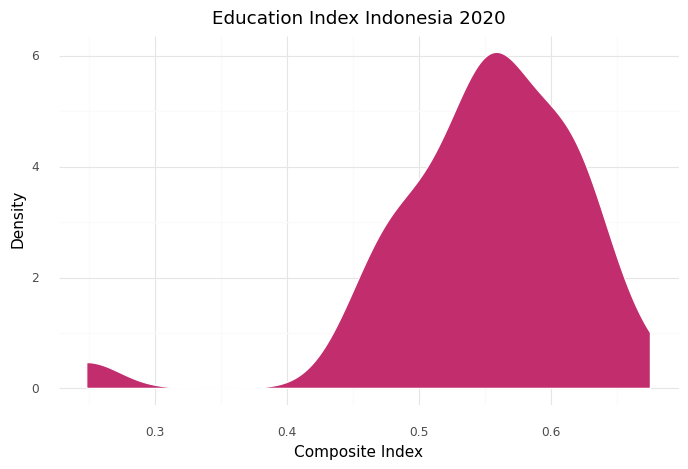

<ggplot: (136905662949)>

In [57]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
composite_index_distribution = (
    ggplot(data = df_index)+
    geom_density(aes(x = 'Composite Index'),
                 color = 'white',
                 fill = '#c22d6d')+
    labs(title = 'Education Index Indonesia 2020')+
    xlab('Composite Index')+
    ylab('Density')+
    theme_minimal()
)
# Display the viz
composite_index_distribution


Education index by province
To visualize the entire education index and its index status, we use the bar plot and highlight the index status — whether they are above or below the global average. In this plot, we also put the straight line as the marker of an average composite index.

Visually, 19 of 34 provinces are categorized as the province that has an education index greater than the global average.

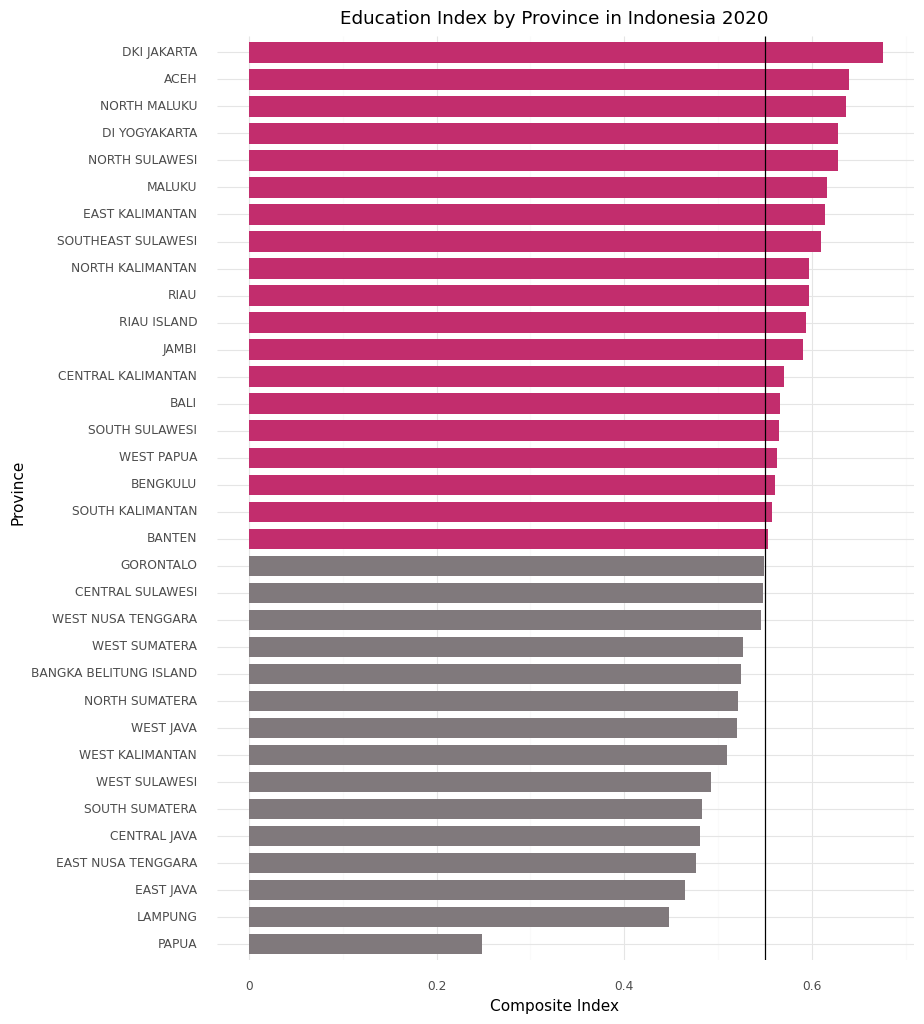

<ggplot: (136905659880)>

In [58]:
# Redefine the data
df_index_reverse = df_index.sort_values(by = 'Rank', ascending = False).reset_index(drop = True)
# Data viz
plotnine.options.figure_size = (9, 12)
composite_index_province = (
    ggplot(data = df_index_reverse)+
    geom_bar(aes(x = 'Province',
                 y = 'Composite Index'),
             width = 0.75,
             fill = np.where(df_index_reverse['Status'] == 'Above','#c22d6d','#80797c'),
             stat = 'identity')+
    geom_hline(yintercept = df_index_reverse['Composite Index'].mean())+
    scale_x_discrete(limits = df_index_reverse['Province'].tolist())+
    labs(title = 'Education Index by Province in Indonesia 2020')+
    xlab('Province')+
    ylab('Composite Index')+
    coord_flip()+
    theme_minimal()
)
# Display the viz
composite_index_province

#### Contribution of factors for education index
The calculation of the composite index involves the factors generated by factor analysis. We can inspect the contribution of each factor to the composite index — the education index. Previously, we restructure the data from a wide format into a long format using melt method in pandas.

In [59]:
# Redefine the data
df_contribution = pd.melt(frame = df_index_reverse,
                          id_vars = 'Province',
                          value_vars = facs,
                          var_name = 'Factor',
                          value_name = 'Factor Value')
df_contribution

,Province,Factor,Factor Value
0,PAPUA,Factors 1,0.000000
1,LAMPUNG,Factors 1,0.219731
2,EAST JAVA,Factors 1,0.215459
3,EAST NUSA TENGGARA,Factors 1,0.206942
4,CENTRAL JAVA,Factors 1,0.214510
...,...,...,...
199,NORTH SULAWESI,Factors 6,0.042260
200,DI YOGYAKARTA,Factors 6,0.035115
201,NORTH MALUKU,Factors 6,0.019639
202,ACEH,Factors 6,0.047016


From the stacked bar plot of the education index, Gorontalo is one of the provinces whose 6th factor has no contribution to the education index. Further, 1st factor in Papua also has no contribution.

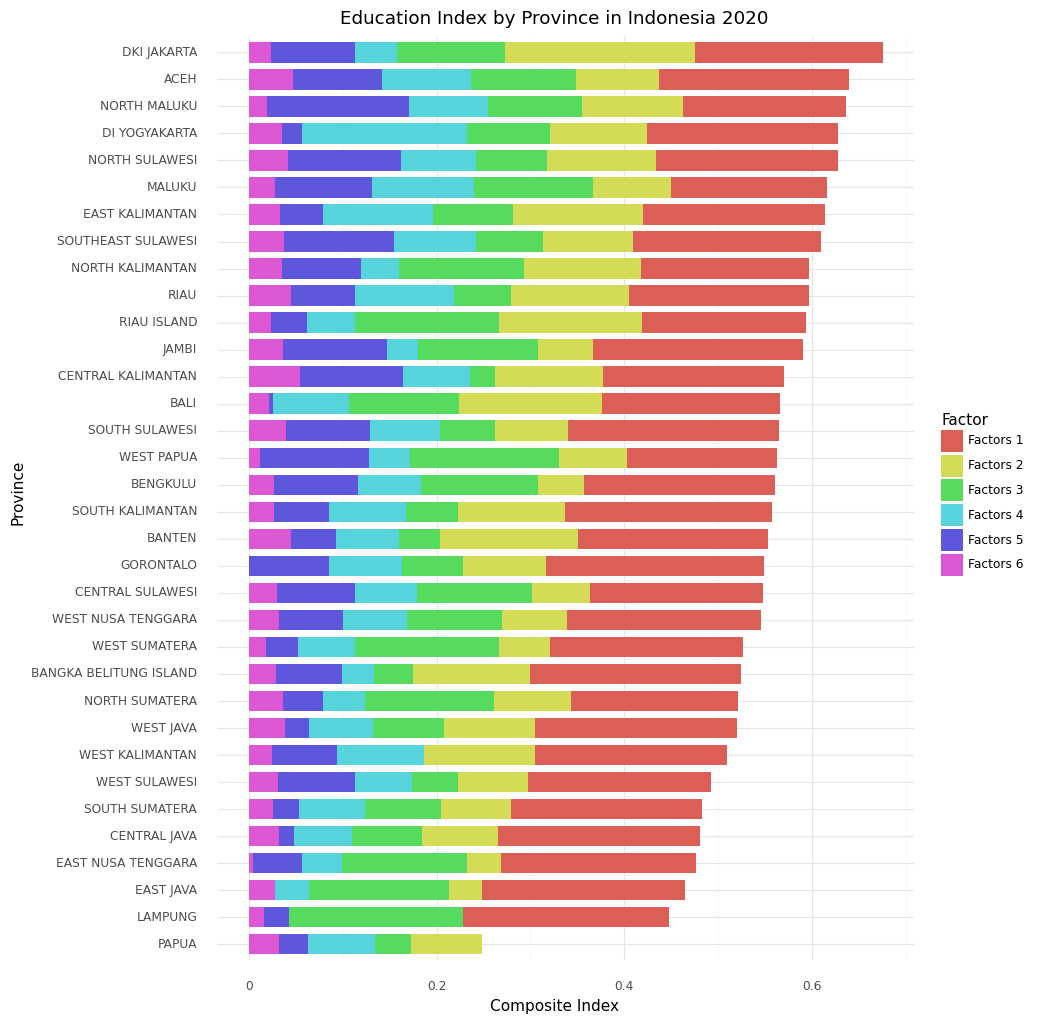

<ggplot: (136904810864)>

In [60]:
# Data viz
plotnine.options.figure_size = (9, 12)
contribution_factors_composite_index = (
    ggplot(data = df_contribution)+
    geom_bar(aes(x = 'Province',
                 y = 'Factor Value',
                 fill = 'Factor'),
             width = 0.75,
             position = 'stack',
             stat = 'identity')+
    scale_x_discrete(limits = df_index_reverse['Province'].tolist())+
    labs(title = 'Education Index by Province in Indonesia 2020')+
    xlab('Province')+
    ylab('Composite Index')+
    coord_flip()+
    theme_minimal()
)
# Display the viz
contribution_factors_composite_index

Explore the education index in western Indonesia.



In [61]:
# West region
df_index[df_index['Region'] == 'West']

,Province,Region,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6,Composite Index,Rank,Status
0,DKI JAKARTA,West,0.200389,0.201341,0.115874,0.043900,0.089914,0.023593,0.675010,1.0,Above
1,ACEH,West,0.201991,0.088058,0.111502,0.095218,0.094912,0.047016,0.638697,2.0,Above
3,DI YOGYAKARTA,West,0.202914,0.102804,0.088724,0.176202,0.021254,0.035115,0.627013,4.0,Above
9,RIAU,West,0.191519,0.125554,0.060936,0.104750,0.068498,0.044904,0.596161,10.0,Above
10,RIAU ISLAND,West,0.175006,0.151281,0.154005,0.050418,0.038577,0.023975,0.593262,11.0,Above
11,JAMBI,West,0.223554,0.058681,0.128134,0.032835,0.110511,0.036768,0.590483,12.0,Above
12,CENTRAL KALIMANTAN,West,0.192577,0.114370,0.026923,0.071344,0.109895,0.054440,0.569548,13.0,Above
16,BENGKULU,West,0.203448,0.049227,0.124613,0.067338,0.089375,0.026782,0.560782,17.0,Above
18,BANTEN,West,0.201559,0.147797,0.043665,0.067148,0.047066,0.045426,0.552661,19.0,Above
22,WEST SUMATERA,West,0.206013,0.053522,0.153202,0.061361,0.033656,0.018639,0.526394,23.0,Below


Explore the education index in central Indonesia.



In [62]:
# Central region
df_index[df_index['Region'] == 'Central']

,Province,Region,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6,Composite Index,Rank,Status
4,NORTH SULAWESI,Central,0.193532,0.115490,0.075847,0.080267,0.119573,0.042260,0.626969,5.0,Above
6,EAST KALIMANTAN,Central,0.193620,0.138853,0.085336,0.116272,0.046547,0.032987,0.613614,7.0,Above
7,SOUTHEAST SULAWESI,Central,0.199485,0.096840,0.070293,0.087865,0.117310,0.037360,0.609152,8.0,Above
8,NORTH KALIMANTAN,Central,0.179277,0.124658,0.133095,0.040594,0.083217,0.035963,0.596804,9.0,Above
13,BALI,Central,0.189363,0.152312,0.117265,0.080574,0.004896,0.021164,0.565573,14.0,Above
14,SOUTH SULAWESI,Central,0.224459,0.078474,0.058022,0.074847,0.088991,0.039850,0.564644,15.0,Above
17,SOUTH KALIMANTAN,Central,0.220826,0.113231,0.056180,0.081443,0.058641,0.026962,0.557284,18.0,Above
19,GORONTALO,Central,0.231925,0.088728,0.064246,0.077924,0.085552,0.000000,0.548374,20.0,Below
20,CENTRAL SULAWESI,Central,0.184056,0.062294,0.121894,0.066592,0.082584,0.030146,0.547567,21.0,Below
21,WEST NUSA TENGGARA,Central,0.206955,0.069010,0.100905,0.068254,0.067645,0.032576,0.545346,22.0,Below


Explore the education index in eastern Indonesia.



In [63]:
# East region
df_index[df_index['Region'] == 'East']


,Province,Region,Factors 1,Factors 2,Factors 3,Factors 4,Factors 5,Factors 6,Composite Index,Rank,Status
2,NORTH MALUKU,East,0.174165,0.106911,0.100701,0.083896,0.150799,0.019639,0.636111,3.0,Above
5,MALUKU,East,0.166540,0.082791,0.126111,0.109298,0.102882,0.028169,0.615790,6.0,Above
15,WEST PAPUA,East,0.159122,0.072640,0.159038,0.043183,0.116128,0.012252,0.562362,16.0,Above
33,PAPUA,East,0.000000,0.075569,0.038739,0.071085,0.030425,0.032620,0.248439,34.0,Below


When the education index is grouped by the region in Indonesia — western, central, and eastern Indonesia, we can easily get the detailed characteristics. Visually, the average education index in each region is different. Eastern Indonesia has the lowest average education index but has the highest median.

_Two-sample t-test for difference of means is recommended to perform_

In [64]:
# Basic statistics
df_index.groupby('Region').agg(
    {
        'Composite Index': ['mean', 'median']
    }
).reset_index()

Region Composite Index          
                      mean    median
0  Central        0.561950  0.560964
1     East        0.515675  0.589076
2     West        0.548805  0.539528

One statistic that we missed before is variance — it gives us information about the variability from the average of each region in Indonesia. Visually, eastern Indonesia has the highest variance rather to western and central Indonesia. It means eastern Indonesia has the highest gap in the education index.

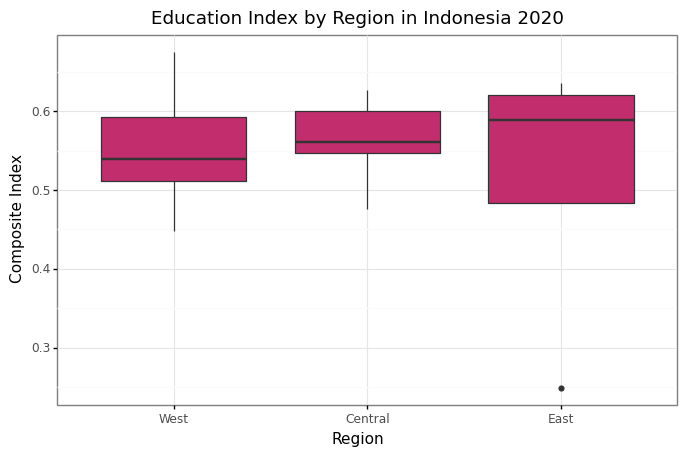

<ggplot: (136905738018)>

In [65]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
composite_index_region = (
    ggplot(data = df_index)+
    geom_boxplot(aes(x = 'Region',
                     y = 'Composite Index'),
                     fill = '#c22d6d',
                 show_legend = False)+
    scale_x_discrete(limits = ['West', 'Central', 'East'])+
    labs(title = 'Education Index by Region in Indonesia 2020')+
    xlab('Region')+
    ylab('Composite Index')+
    theme_bw()
)
# Display the viz
composite_index_region

Besides the statistical value, we compared the region in Indonesia, we will group the 34 provinces into their region and index status category. The question that will be answered is eastern Indonesia has the highest composition of below status?

In [66]:
# Basic statistics
df_region_status = df_index.groupby(['Region', 'Status'])['Province'].count().reset_index()
df_region_status

,Region,Status,Province
0,Central,Above,7
1,Central,Below,5
2,East,Above,3
3,East,Below,1
4,West,Above,9
5,West,Below,9


The answer after plotting the cross-tabulation: western Indonesia has the highest composition of below status. It means the policymaker must take attention to western Indonesia intensively.

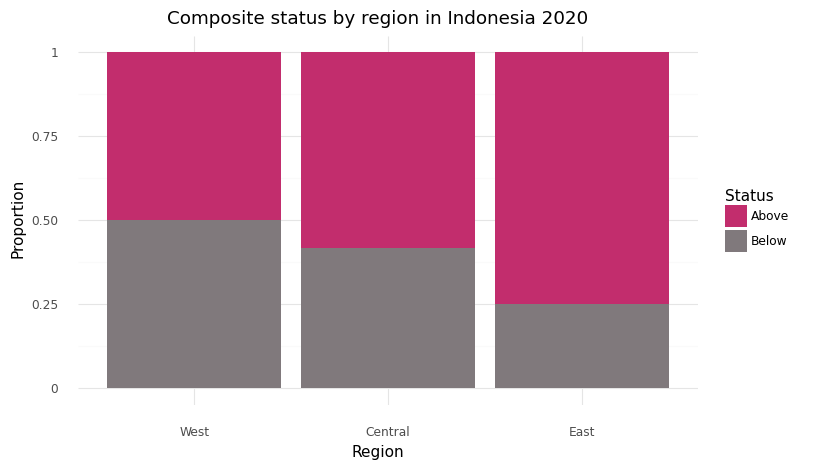

<ggplot: (136905757437)>

In [67]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
composite_index_status_region = (
    ggplot(data = df_region_status)+
    geom_bar(aes(x = 'Region',
                 y = 'Province',
                 fill = 'Status'),
             stat = 'identity',
             position = 'fill')+
    labs(title = 'Composite status by region in Indonesia 2020')+
    xlab('Region')+
    ylab('Proportion')+
    scale_x_discrete(limits = ['West', 'Central', 'East'])+
    scale_fill_manual(values = ['#c22d6d','#80797c'], labels = ['Above', 'Below'])+
    theme_minimal()
)
# Display the viz
composite_index_status_region

The last visualization is a choropleth map to make the audience easier to understand the education index through the map. It needs the Geojson file for the Indonesia area. It is used to map the value of the education index into the choropleth.

In [125]:
# Load the JSON file
with open('./data/prov_light.json') as json_file:
    idn = gpd.GeoDataFrame.from_features

province = df_index.merge(df[['Province', 'Code']], on='Province', how="left")

# Merge the idn and province dataframe
IND = pd.merge(left = idn, right = province, how = 'inner', left_on = 'KODE', right_on = 'Code')
# Create a colormap
colormap = cm.LinearColormap(
              colors = ['#f52020', '#2035f5'],
              vmin = province['Composite Index'].min(),
              vmax = province['Composite Index'].max())
# Create a white image of 4 pixels, and embed it in a url
white_tile = branca.utilities.image_to_url([[1, 1], [1, 1]])
# Create a map object
map_file = folium.Map(location =[0.8, 113],
                      tiles = white_tile, 
                      attr = 'white tile',
                      zoom_start = 6)
# Make a tooltip
tooltip = GeoJsonTooltip(
    fields = ['Province', 'Composite Index'],
    aliases = ['Province Name:', 'Education Index:'],
    localize = True,
    sticky = True,
    labels = True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """)
# Add to the map
geo = folium.GeoJson(
            IND,
            style_function = lambda x: {'fillColor': colormap(x['properties']['Composite Index']),
                         'color' : 'black',
                         'fillOpacity' : 1.00},
             tooltip = tooltip).add_to(map_file)
colormap.add_to(map_file)

TypeError: Can only merge Series or DataFrame objects, a <class 'method'> was passed

## Conclusion
There are steps for constructing a composite indicator, such as selecting variables, multivariate analysis — factor analysis in this tutorial, data normalization, data weighting and aggregation, and robustness and sensitivity analysis. Each step has a different method and different methods can make the output or result — composite index become different. It can be the benchmark for policymakers to create a strategic decision for improving the previous policy and make a better result.

References:

[1] [BPS] Badan Pusat Statistik. [Potret Pendidikan Indonesia: Statistik Pendidikan 2020](https://www.bps.go.id/publication/download.html?nrbvfeve=MzQ3Yzg1NTQxYzM0ZTdkYWU1NDM5NWEz&xzmn=aHR0cHM6Ly93d3cuYnBzLmdvLmlkL3B1YmxpY2F0aW9uLzIwMjAvMTEvMjcvMzQ3Yzg1NTQxYzM0ZTdkYWU1NDM5NWEzL3N0YXRpc3Rpay1wZW5kaWRpa2FuLTIwMjAuaHRtbA%3D%3D&twoadfnoarfeauf=MjAyMS0wNS0xMCAxMDowNjowNQ%3D%3D) (2020), Jakarta (ID): Badan Pusat Statistik.

[2] [OECD] Organization for Economic Co-operation and Development. [Handbook on Constructing Composite Indicators: Methodology and User Guide](https://www.oecd.org/sdd/42495745.pdf) (2008), OECD.